In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
import heapq
from collections import defaultdict

def compute_fitness(individual):
    return np.sum(np.square(individual))

def compute_inertia(data, labels, centroids):
    inertia = 0.0
    for i, point in enumerate(data):
        label = labels[i]
        if label == -1:
            continue  # noise ignoruj
        inertia += np.sum((point - centroids[label]) ** 2)
    return inertia


def optics_clustering(data, min_samples=5, eps=np.inf):
    n = len(data)
    reachability = np.full(n, np.inf)
    processed = np.zeros(n, dtype=bool)
    ordering = []
    neighbors_dict = {}

    distances = cdist(data, data)

    def get_neighbors(point_idx):
        if point_idx not in neighbors_dict:
            neighbors_dict[point_idx] = np.where(distances[point_idx] <= eps)[0]
        return neighbors_dict[point_idx]

    def update_reachability(seeds, center_idx, neighbors):
        core_dist = np.sort(distances[center_idx])[min_samples]
        if core_dist == 0 or np.isinf(core_dist):
            return

        for neighbor in neighbors:
            if not processed[neighbor]:
                new_reachability = max(core_dist, distances[center_idx, neighbor])
                if new_reachability < reachability[neighbor]:
                    reachability[neighbor] = new_reachability
                    heapq.heappush(seeds, (new_reachability, neighbor))

    def expand_cluster(start_idx):
        seeds = []
        reachability[start_idx] = 0
        ordering.append(start_idx)
        processed[start_idx] = True

        neighbors = get_neighbors(start_idx)
        if len(neighbors) >= min_samples:
            update_reachability(seeds, start_idx, neighbors)

        while seeds:
            _, new_point = heapq.heappop(seeds)
            if not processed[new_point]:
                processed[new_point] = True
                ordering.append(new_point)
                new_neighbors = get_neighbors(new_point)
                if len(new_neighbors) >= min_samples:
                    update_reachability(seeds, new_point, new_neighbors)

    for i in range(n):
        if not processed[i]:
            expand_cluster(i)

    clusters = np.full(n, -1)
    cluster_id = 0
    reachability_threshold = np.percentile(reachability, 98)

    for i in range(1, len(ordering)):
        if reachability[ordering[i]] > reachability_threshold:
            cluster_id += 1
        clusters[ordering[i]] = cluster_id

    return clusters

def run(dataset, min_samples, step):
    centroid_history = []
    df = pd.read_csv(dataset)

    unique_generations = sorted(df["generation"].unique())

    selected_generations = [unique_generations[0]] + unique_generations[step-1::step] + [unique_generations[-1]]

    first_gen_data = df[df["generation"] == unique_generations[0]].drop(columns=["generation", "id"]).values
    pca = PCA(n_components=2)
    pca.fit(first_gen_data)
    id_cluster_map = defaultdict(list)
    cluster_counts = []
    cluster_size_history = []
    inertia_history = []


    for gen in selected_generations:
        pop_data = df[df["generation"] == gen].drop(columns=["generation", "id"]).values
        reduced_data = pca.transform(pop_data)

        max_distance = np.max(cdist(reduced_data, reduced_data))
        eps = 0.25 * max_distance

        clusters = optics_clustering(pop_data, min_samples=min_samples, eps=eps)

        centroids = []
        for i in range(min(clusters), max(clusters)+1):
            if i == -1:
                continue
            members = pop_data[clusters == i]
            if len(members) > 0:
                centroid = np.mean(members, axis=0)
                centroids.append(centroid)
        centroid_history.append(centroids)
        inertia = compute_inertia(pop_data, clusters, centroids)
        inertia_history.append(inertia)



        num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
        cluster_counts.append(num_clusters)
        ids = df[df["generation"] == gen]["id"].values
        for ident, cl in zip(ids, clusters):
            id_cluster_map[ident].append(cl)
        sizes = []
        for i in range(-1, max(clusters)+1):
            sizes.append(np.sum(clusters == i))
        cluster_size_history.append(sizes)

        plt.figure(figsize=(6, 6))
        plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis', alpha=0.7)
        plt.title(f"Generation {gen} - Improved Custom OPTICS Clustering")
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.colorbar(label="Cluster Label")
        plt.show()

        # === Histogram velikostí clusterů (distribuce) ===
        unique_labels = sorted(set(clusters))
        cluster_sizes = [np.sum(clusters == label) for label in unique_labels]

        plt.figure(figsize=(8, 4))
        plt.bar([str(label) for label in unique_labels], cluster_sizes, color='skyblue', edgecolor='black')
        plt.xlabel("Cluster ID")
        plt.ylabel("Počet jedinců")
        plt.title(f"Distribuce velikostí clusterů - generace {gen}")
        plt.grid(axis='y')
        plt.tight_layout()
        plt.show()

        # === Analýza stability clusterů mezi generacemi ===
        if len(id_cluster_map[next(iter(id_cluster_map))]) > 1:
            stability = {i: [] for i in range(num_clusters)}  # cluster_id → seznam počtů přeběhlíků

            for gen_idx in range(1, len(selected_generations)):
                current_gen = selected_generations[gen_idx]
                previous_gen = selected_generations[gen_idx - 1]

                cluster_transitions = defaultdict(lambda: defaultdict(int))  # prev_cluster -> current_cluster -> count

                for ident, history in id_cluster_map.items():
                    if len(history) > gen_idx:
                        prev_label = history[gen_idx - 1]
                        curr_label = history[gen_idx]
                        cluster_transitions[prev_label][curr_label] += 1

                print(f"\nStabilita mezi generací {previous_gen} → {current_gen}:")
                for prev_label, curr_counts in cluster_transitions.items():
                    total = sum(curr_counts.values())
                    for curr_label, count in curr_counts.items():
                        print(f"  Cluster {prev_label} → {curr_label}: {count} jedinců ({count/total*100:.1f} %)")


        switch_counts = {}
        for ident, history in id_cluster_map.items():
            switches = sum(1 for a, b in zip(history, history[1:]) if a != b)
            switch_counts[ident] = switches

        total = len(switch_counts)
        same = sum(1 for s in switch_counts.values() if s == 0)
        once = sum(1 for s in switch_counts.values() if s == 1)
        many = sum(1 for s in switch_counts.values() if s > 1)

        print("Statistiky pohybu mezi clustery:")
        print(f"Celkem jedinců: {total}")
        print(f"Zůstali ve stejném clusteru: {same} ({same/total*100:.1f} %)")
        print(f"Změnili cluster jednou: {once} ({once/total*100:.1f} %)")
        print(f"Změnili cluster vícekrát: {many} ({many/total*100:.1f} %)")

        # === Boxplot fitness hodnot v jednotlivých clusterech ===
        gen_data = df[df["generation"] == gen]
        pop_values = gen_data.drop(columns=["generation", "id"]).values
        fitness_values = np.array([compute_fitness(ind) for ind in pop_values])

        # Získání unikátních cluster ID (vynecháme -1 = noise)
        cluster_ids = sorted(set(clusters) - {-1})

        # Inicializace slovníku
        cluster_fitness = {cl: [] for cl in cluster_ids}

        # Naplnění fitness hodnot do jednotlivých clusterů
        for i, cl in enumerate(clusters):
            if cl in cluster_fitness:
                cluster_fitness[cl].append(fitness_values[i])

        # Vykreslení boxplotu
        plt.figure(figsize=(8, 5))
        plt.boxplot([cluster_fitness[cl] for cl in cluster_ids],
                    labels=[f"Cluster {cl}" for cl in cluster_ids])
        plt.xlabel("Cluster")
        plt.ylabel("Fitness")
        plt.title(f"Distribuce fitness hodnot – generace {gen}")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


    plt.figure(figsize=(8, 4))
    plt.plot(selected_generations, cluster_counts, marker='o')
    plt.xlabel("Generace")
    plt.ylabel("Počet clusterů")
    plt.title("Vývoj počtu clusterů v čase")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    max_cluster_id = max(len(sizes) for sizes in cluster_size_history)
    cluster_size_array = np.zeros((len(cluster_size_history), max_cluster_id))
    for i, sizes in enumerate(cluster_size_history):
        for j, size in enumerate(sizes):
            cluster_size_array[i, j] = size

    plt.figure(figsize=(12, 5))
    for j in range(cluster_size_array.shape[1]):
        plt.plot(selected_generations, cluster_size_array[:, j], label=f"Cluster {j - 1 if -1 in sizes else j}")
    plt.xlabel("Generace")
    plt.ylabel("Počet jedinců")
    plt.title("Vývoj velikosti clusterů v čase")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Vývoj průměrné vzdálenosti mezi centroidy ===
    average_intercentroid_distances = []
    for centroids in centroid_history:
        if len(centroids) < 2:
            average_intercentroid_distances.append(0)
            continue
        dists = cdist(centroids, centroids)
        upper_triangle = dists[np.triu_indices_from(dists, k=1)]
        avg_dist = np.mean(upper_triangle)
        average_intercentroid_distances.append(avg_dist)

    plt.figure(figsize=(10, 4))
    plt.plot(selected_generations, average_intercentroid_distances, marker='o', color='purple')
    plt.xlabel("Generace")
    plt.ylabel("Průměrná vzdálenost mezi centroidy")
    plt.title("Vývoj vzdáleností mezi centroidy (OPTICS)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    for i in range(len(centroid_history) - 1):
        print(f"\nPosun centroidů mezi generací {selected_generations[i]} a {selected_generations[i+1]}:")
        for j in range(min(len(centroid_history[i]), len(centroid_history[i+1]))):
            dist = np.linalg.norm(centroid_history[i][j] - centroid_history[i+1][j])
            print(f" - Cluster {j}: {dist:.4f}")

    # === Vývoj WCSS ===
    plt.figure(figsize=(8, 4))
    plt.plot(selected_generations, inertia_history, marker='o')
    plt.xlabel("Generace")
    plt.ylabel("WCSS (inercie)")
    plt.title("Vývoj kvality clusterů (inercie) – OPTICS")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

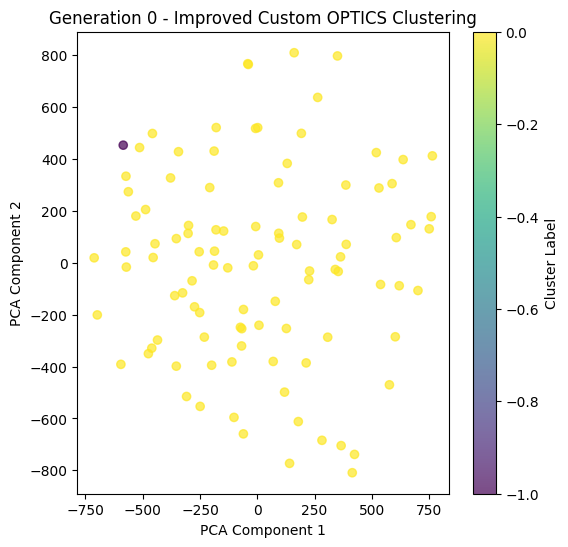

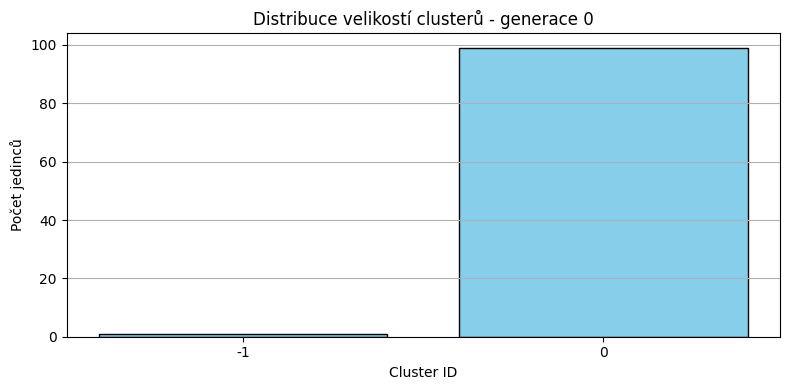

Statistiky pohybu mezi clustery:
Celkem jedinců: 100
Zůstali ve stejném clusteru: 100 (100.0 %)
Změnili cluster jednou: 0 (0.0 %)
Změnili cluster vícekrát: 0 (0.0 %)


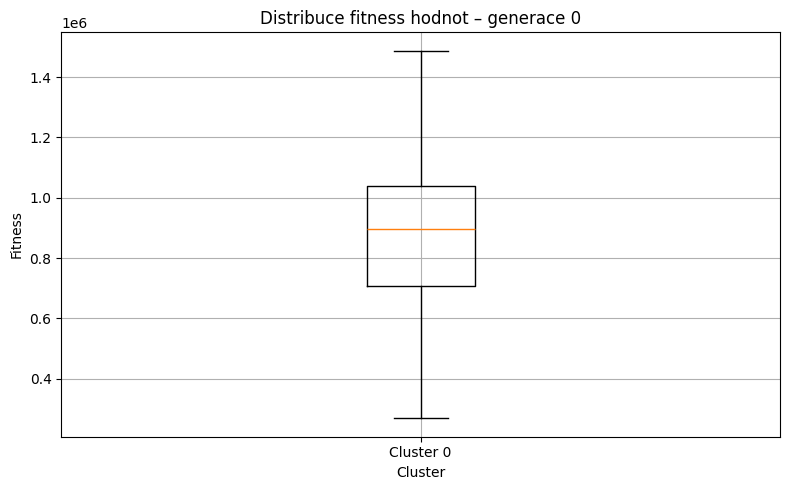

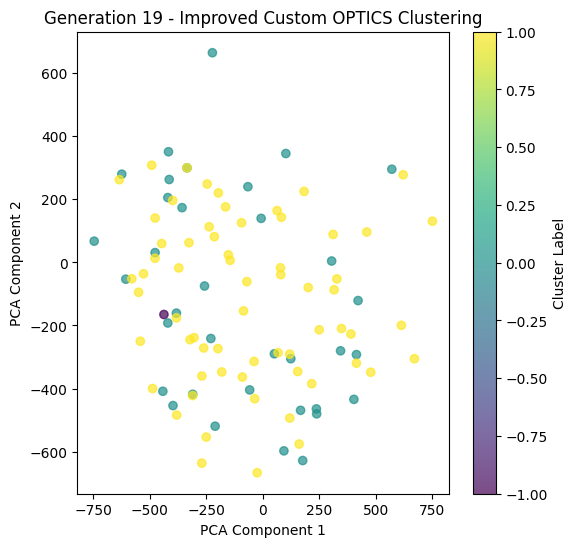

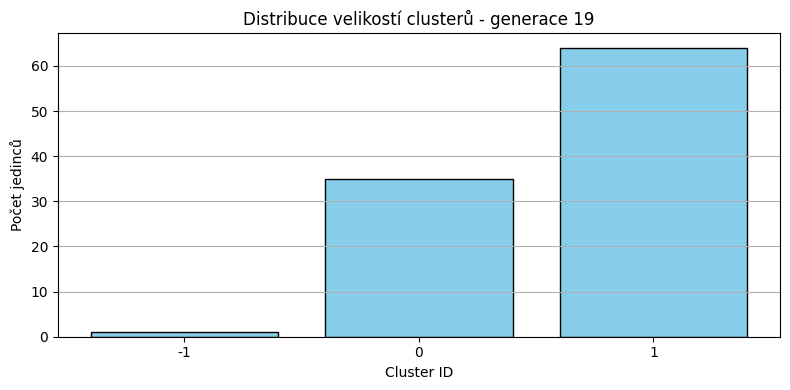


Stabilita mezi generací 0 → 19:
  Cluster -1 → -1: 1 jedinců (100.0 %)
  Cluster 0 → 0: 35 jedinců (35.4 %)
  Cluster 0 → 1: 64 jedinců (64.6 %)

Stabilita mezi generací 19 → 39:

Stabilita mezi generací 39 → 59:

Stabilita mezi generací 59 → 79:

Stabilita mezi generací 79 → 99:

Stabilita mezi generací 99 → 119:

Stabilita mezi generací 119 → 139:

Stabilita mezi generací 139 → 159:

Stabilita mezi generací 159 → 179:

Stabilita mezi generací 179 → 198:
Statistiky pohybu mezi clustery:
Celkem jedinců: 100
Zůstali ve stejném clusteru: 36 (36.0 %)
Změnili cluster jednou: 64 (64.0 %)
Změnili cluster vícekrát: 0 (0.0 %)


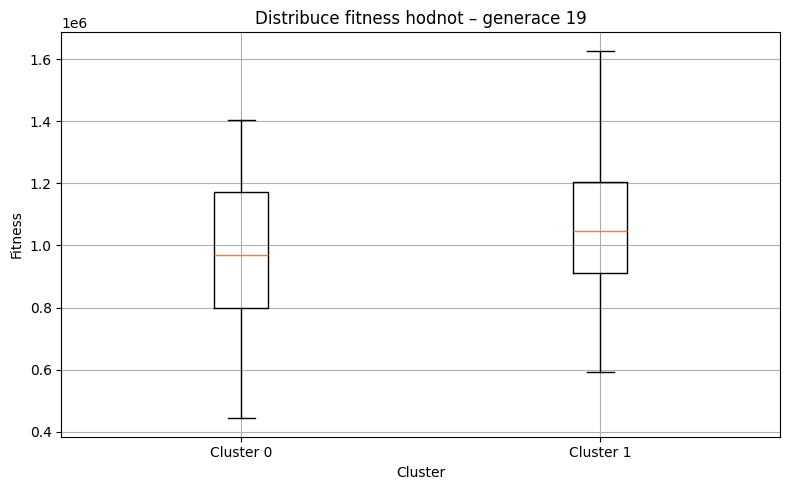

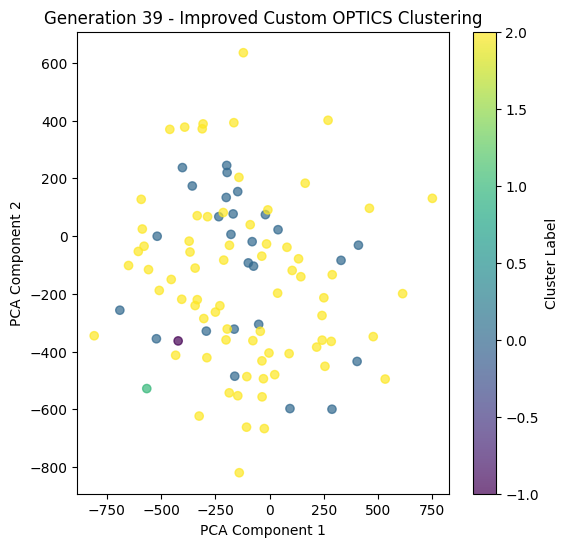

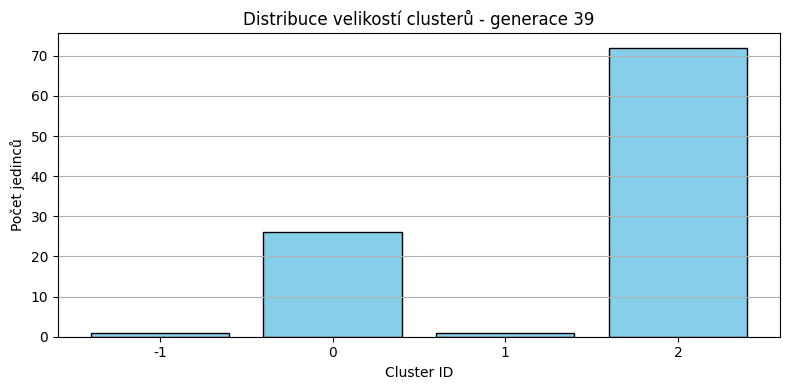


Stabilita mezi generací 0 → 19:
  Cluster -1 → -1: 1 jedinců (100.0 %)
  Cluster 0 → 0: 35 jedinců (35.4 %)
  Cluster 0 → 1: 64 jedinců (64.6 %)

Stabilita mezi generací 19 → 39:
  Cluster -1 → -1: 1 jedinců (100.0 %)
  Cluster 0 → 0: 22 jedinců (62.9 %)
  Cluster 0 → 2: 12 jedinců (34.3 %)
  Cluster 0 → 1: 1 jedinců (2.9 %)
  Cluster 1 → 2: 60 jedinců (93.8 %)
  Cluster 1 → 0: 4 jedinců (6.2 %)

Stabilita mezi generací 39 → 59:

Stabilita mezi generací 59 → 79:

Stabilita mezi generací 79 → 99:

Stabilita mezi generací 99 → 119:

Stabilita mezi generací 119 → 139:

Stabilita mezi generací 139 → 159:

Stabilita mezi generací 159 → 179:

Stabilita mezi generací 179 → 198:
Statistiky pohybu mezi clustery:
Celkem jedinců: 100
Zůstali ve stejném clusteru: 23 (23.0 %)
Změnili cluster jednou: 13 (13.0 %)
Změnili cluster vícekrát: 64 (64.0 %)


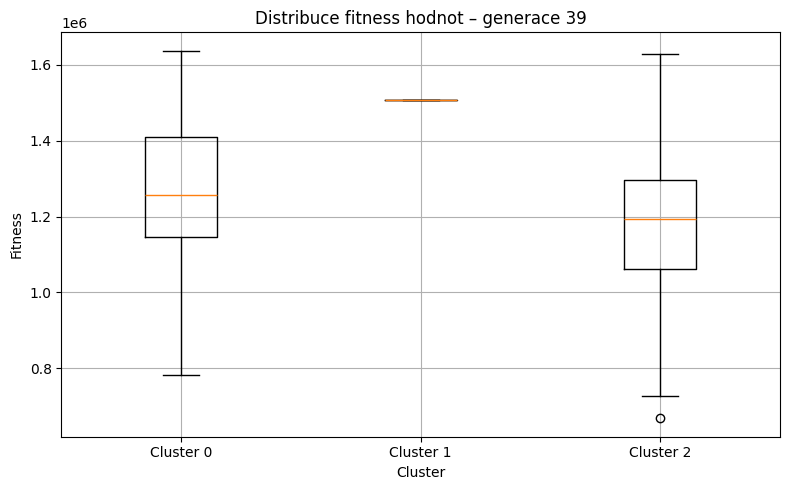

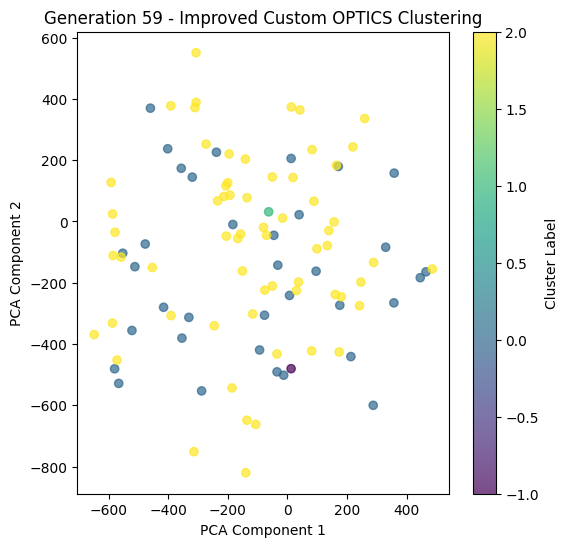

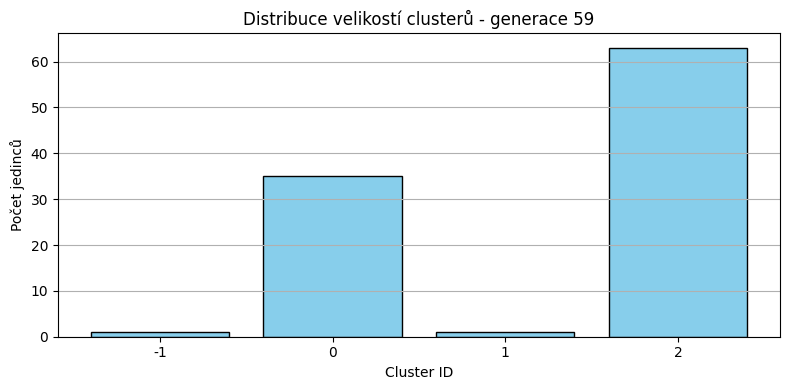


Stabilita mezi generací 0 → 19:
  Cluster -1 → -1: 1 jedinců (100.0 %)
  Cluster 0 → 0: 35 jedinců (35.4 %)
  Cluster 0 → 1: 64 jedinců (64.6 %)

Stabilita mezi generací 19 → 39:
  Cluster -1 → -1: 1 jedinců (100.0 %)
  Cluster 0 → 0: 22 jedinců (62.9 %)
  Cluster 0 → 2: 12 jedinců (34.3 %)
  Cluster 0 → 1: 1 jedinců (2.9 %)
  Cluster 1 → 2: 60 jedinců (93.8 %)
  Cluster 1 → 0: 4 jedinců (6.2 %)

Stabilita mezi generací 39 → 59:
  Cluster -1 → -1: 1 jedinců (100.0 %)
  Cluster 0 → 0: 22 jedinců (84.6 %)
  Cluster 0 → 2: 4 jedinců (15.4 %)
  Cluster 2 → 0: 12 jedinců (16.7 %)
  Cluster 2 → 2: 59 jedinců (81.9 %)
  Cluster 2 → 1: 1 jedinců (1.4 %)
  Cluster 1 → 0: 1 jedinců (100.0 %)

Stabilita mezi generací 59 → 79:

Stabilita mezi generací 79 → 99:

Stabilita mezi generací 99 → 119:

Stabilita mezi generací 119 → 139:

Stabilita mezi generací 139 → 159:

Stabilita mezi generací 159 → 179:

Stabilita mezi generací 179 → 198:
Statistiky pohybu mezi clustery:
Celkem jedinců: 100
Zůstali 

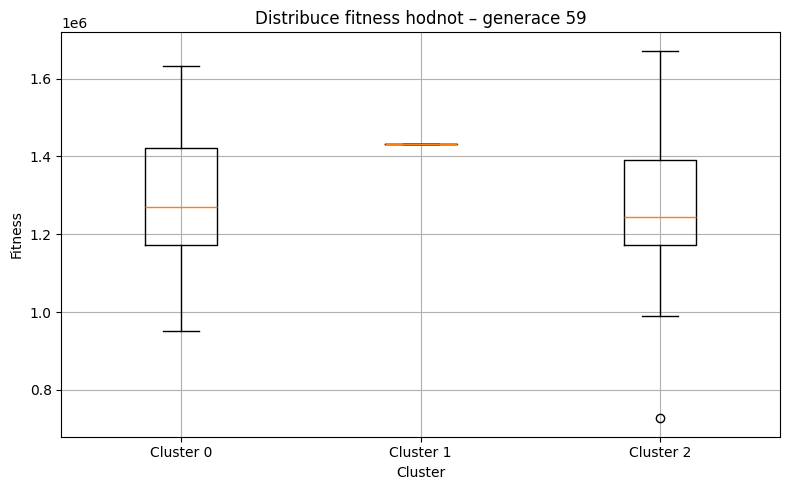

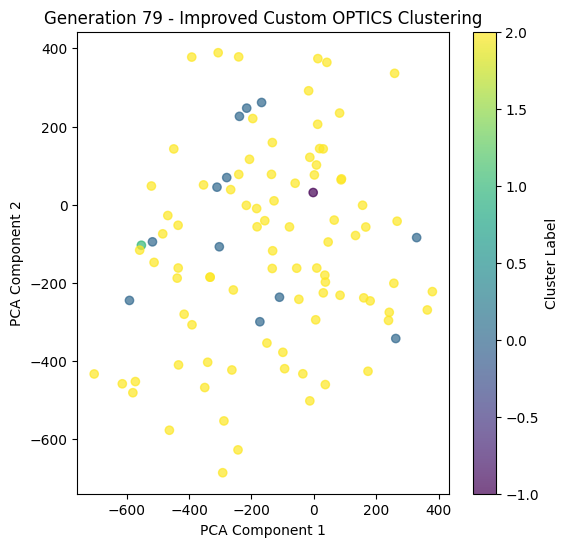

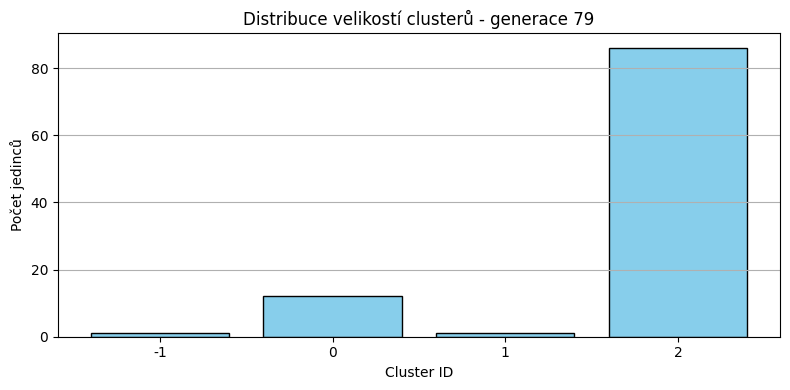


Stabilita mezi generací 0 → 19:
  Cluster -1 → -1: 1 jedinců (100.0 %)
  Cluster 0 → 0: 35 jedinců (35.4 %)
  Cluster 0 → 1: 64 jedinců (64.6 %)

Stabilita mezi generací 19 → 39:
  Cluster -1 → -1: 1 jedinců (100.0 %)
  Cluster 0 → 0: 22 jedinců (62.9 %)
  Cluster 0 → 2: 12 jedinců (34.3 %)
  Cluster 0 → 1: 1 jedinců (2.9 %)
  Cluster 1 → 2: 60 jedinců (93.8 %)
  Cluster 1 → 0: 4 jedinců (6.2 %)

Stabilita mezi generací 39 → 59:
  Cluster -1 → -1: 1 jedinců (100.0 %)
  Cluster 0 → 0: 22 jedinců (84.6 %)
  Cluster 0 → 2: 4 jedinců (15.4 %)
  Cluster 2 → 0: 12 jedinců (16.7 %)
  Cluster 2 → 2: 59 jedinců (81.9 %)
  Cluster 2 → 1: 1 jedinců (1.4 %)
  Cluster 1 → 0: 1 jedinců (100.0 %)

Stabilita mezi generací 59 → 79:
  Cluster -1 → -1: 1 jedinců (100.0 %)
  Cluster 0 → 0: 10 jedinců (28.6 %)
  Cluster 0 → 2: 24 jedinců (68.6 %)
  Cluster 0 → 1: 1 jedinců (2.9 %)
  Cluster 2 → 2: 62 jedinců (98.4 %)
  Cluster 2 → 0: 1 jedinců (1.6 %)
  Cluster 1 → 0: 1 jedinců (100.0 %)

Stabilita mezi g

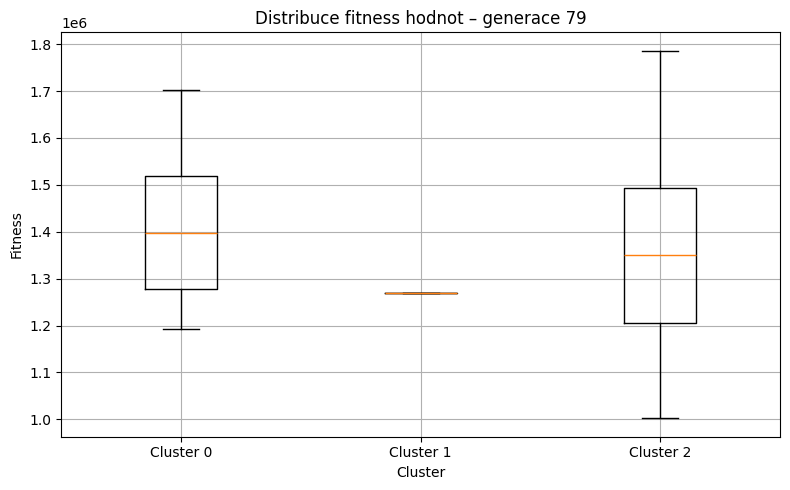

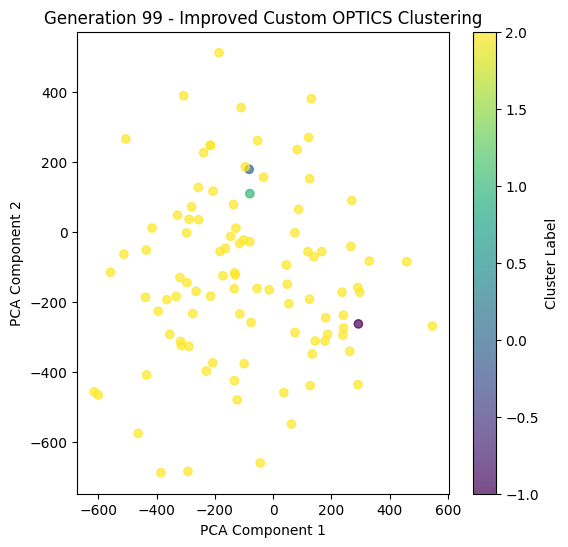

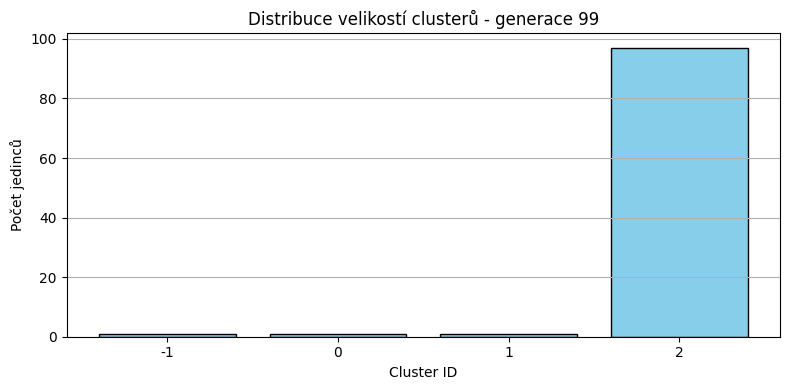


Stabilita mezi generací 0 → 19:
  Cluster -1 → -1: 1 jedinců (100.0 %)
  Cluster 0 → 0: 35 jedinců (35.4 %)
  Cluster 0 → 1: 64 jedinců (64.6 %)

Stabilita mezi generací 19 → 39:
  Cluster -1 → -1: 1 jedinců (100.0 %)
  Cluster 0 → 0: 22 jedinců (62.9 %)
  Cluster 0 → 2: 12 jedinců (34.3 %)
  Cluster 0 → 1: 1 jedinců (2.9 %)
  Cluster 1 → 2: 60 jedinců (93.8 %)
  Cluster 1 → 0: 4 jedinců (6.2 %)

Stabilita mezi generací 39 → 59:
  Cluster -1 → -1: 1 jedinců (100.0 %)
  Cluster 0 → 0: 22 jedinců (84.6 %)
  Cluster 0 → 2: 4 jedinců (15.4 %)
  Cluster 2 → 0: 12 jedinců (16.7 %)
  Cluster 2 → 2: 59 jedinců (81.9 %)
  Cluster 2 → 1: 1 jedinců (1.4 %)
  Cluster 1 → 0: 1 jedinců (100.0 %)

Stabilita mezi generací 59 → 79:
  Cluster -1 → -1: 1 jedinců (100.0 %)
  Cluster 0 → 0: 10 jedinců (28.6 %)
  Cluster 0 → 2: 24 jedinců (68.6 %)
  Cluster 0 → 1: 1 jedinců (2.9 %)
  Cluster 2 → 2: 62 jedinců (98.4 %)
  Cluster 2 → 0: 1 jedinců (1.6 %)
  Cluster 1 → 0: 1 jedinců (100.0 %)

Stabilita mezi g

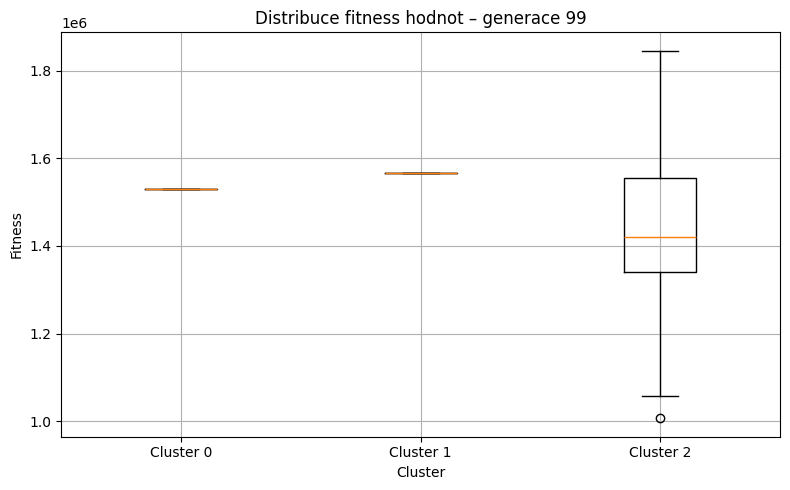

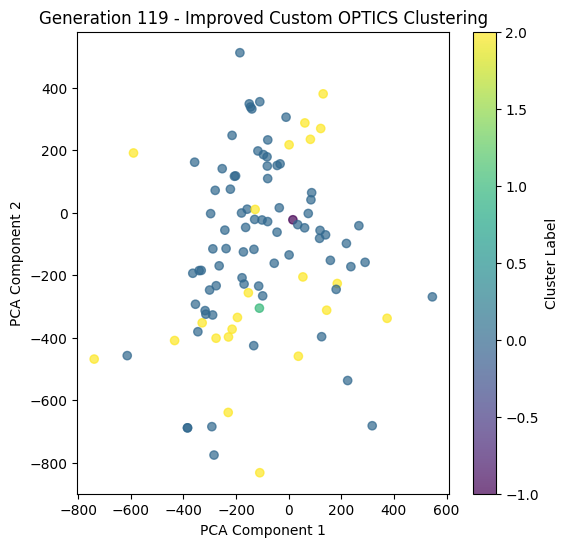

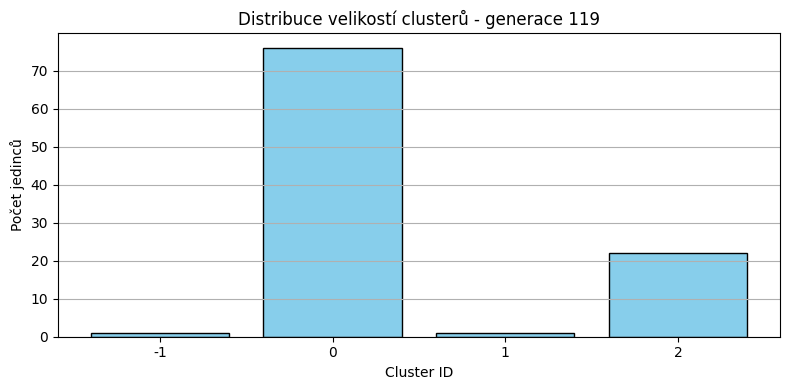


Stabilita mezi generací 0 → 19:
  Cluster -1 → -1: 1 jedinců (100.0 %)
  Cluster 0 → 0: 35 jedinců (35.4 %)
  Cluster 0 → 1: 64 jedinců (64.6 %)

Stabilita mezi generací 19 → 39:
  Cluster -1 → -1: 1 jedinců (100.0 %)
  Cluster 0 → 0: 22 jedinců (62.9 %)
  Cluster 0 → 2: 12 jedinců (34.3 %)
  Cluster 0 → 1: 1 jedinců (2.9 %)
  Cluster 1 → 2: 60 jedinců (93.8 %)
  Cluster 1 → 0: 4 jedinců (6.2 %)

Stabilita mezi generací 39 → 59:
  Cluster -1 → -1: 1 jedinců (100.0 %)
  Cluster 0 → 0: 22 jedinců (84.6 %)
  Cluster 0 → 2: 4 jedinců (15.4 %)
  Cluster 2 → 0: 12 jedinců (16.7 %)
  Cluster 2 → 2: 59 jedinců (81.9 %)
  Cluster 2 → 1: 1 jedinců (1.4 %)
  Cluster 1 → 0: 1 jedinců (100.0 %)

Stabilita mezi generací 59 → 79:
  Cluster -1 → -1: 1 jedinců (100.0 %)
  Cluster 0 → 0: 10 jedinců (28.6 %)
  Cluster 0 → 2: 24 jedinců (68.6 %)
  Cluster 0 → 1: 1 jedinců (2.9 %)
  Cluster 2 → 2: 62 jedinců (98.4 %)
  Cluster 2 → 0: 1 jedinců (1.6 %)
  Cluster 1 → 0: 1 jedinců (100.0 %)

Stabilita mezi g

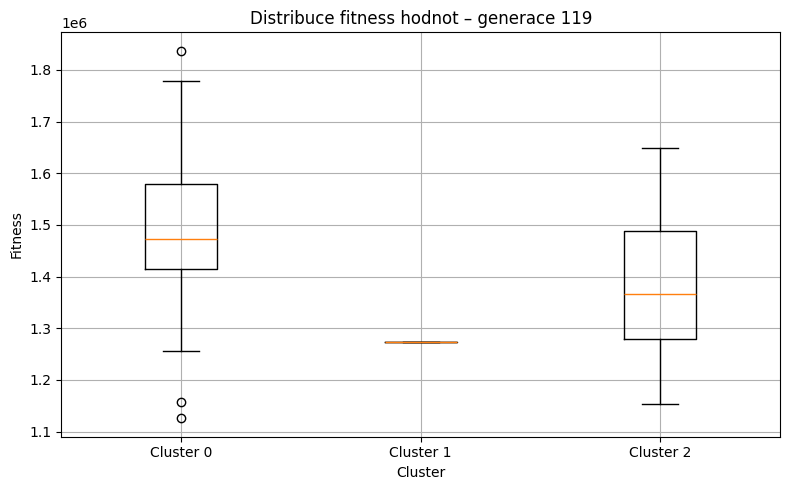

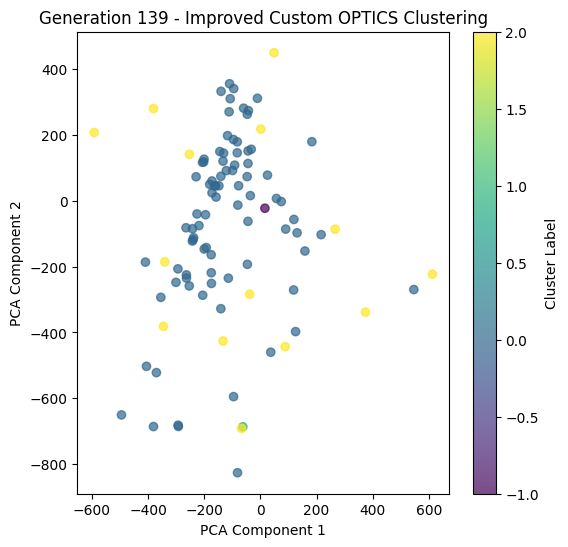

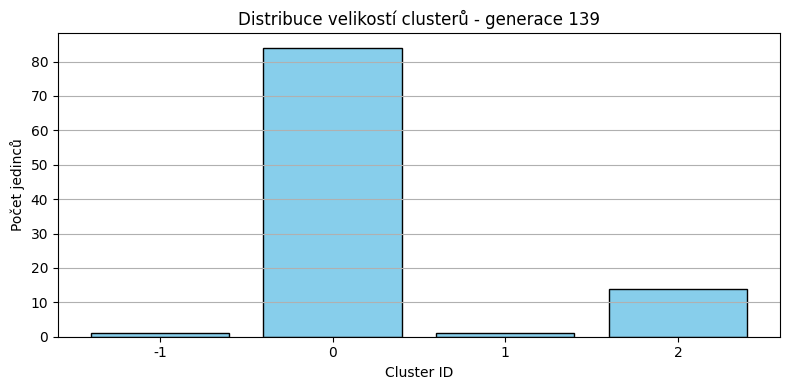


Stabilita mezi generací 0 → 19:
  Cluster -1 → -1: 1 jedinců (100.0 %)
  Cluster 0 → 0: 35 jedinců (35.4 %)
  Cluster 0 → 1: 64 jedinců (64.6 %)

Stabilita mezi generací 19 → 39:
  Cluster -1 → -1: 1 jedinců (100.0 %)
  Cluster 0 → 0: 22 jedinců (62.9 %)
  Cluster 0 → 2: 12 jedinců (34.3 %)
  Cluster 0 → 1: 1 jedinců (2.9 %)
  Cluster 1 → 2: 60 jedinců (93.8 %)
  Cluster 1 → 0: 4 jedinců (6.2 %)

Stabilita mezi generací 39 → 59:
  Cluster -1 → -1: 1 jedinců (100.0 %)
  Cluster 0 → 0: 22 jedinců (84.6 %)
  Cluster 0 → 2: 4 jedinců (15.4 %)
  Cluster 2 → 0: 12 jedinců (16.7 %)
  Cluster 2 → 2: 59 jedinců (81.9 %)
  Cluster 2 → 1: 1 jedinců (1.4 %)
  Cluster 1 → 0: 1 jedinců (100.0 %)

Stabilita mezi generací 59 → 79:
  Cluster -1 → -1: 1 jedinců (100.0 %)
  Cluster 0 → 0: 10 jedinců (28.6 %)
  Cluster 0 → 2: 24 jedinců (68.6 %)
  Cluster 0 → 1: 1 jedinců (2.9 %)
  Cluster 2 → 2: 62 jedinců (98.4 %)
  Cluster 2 → 0: 1 jedinců (1.6 %)
  Cluster 1 → 0: 1 jedinců (100.0 %)

Stabilita mezi g

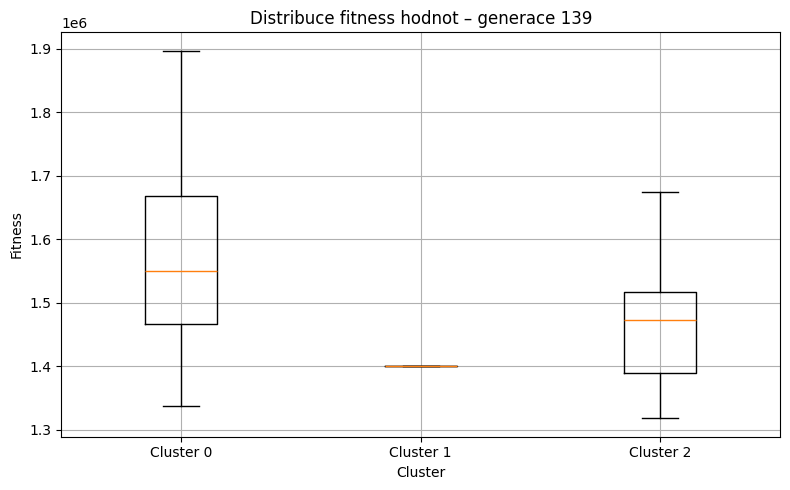

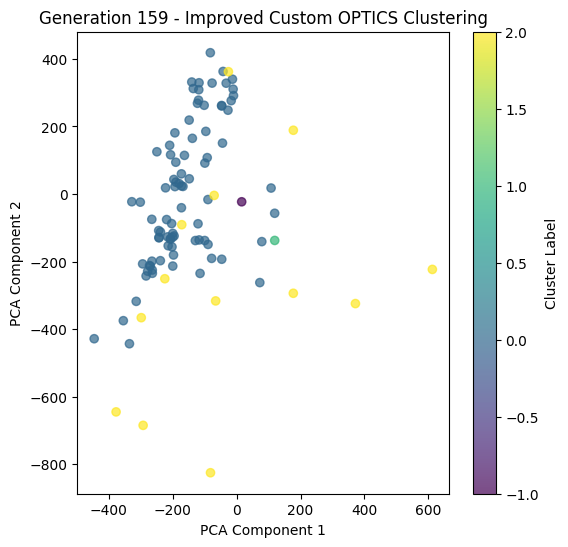

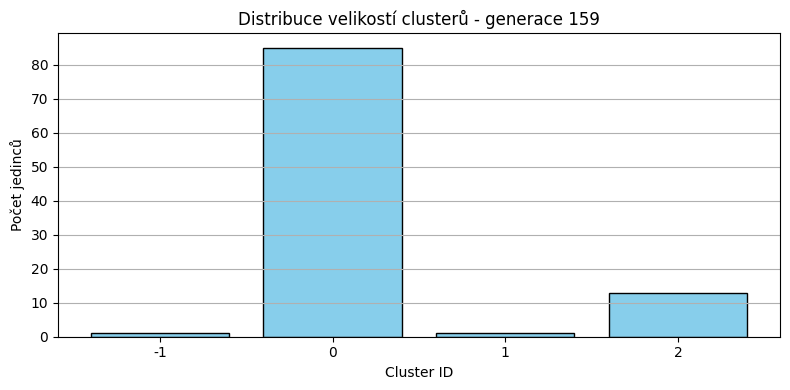


Stabilita mezi generací 0 → 19:
  Cluster -1 → -1: 1 jedinců (100.0 %)
  Cluster 0 → 0: 35 jedinců (35.4 %)
  Cluster 0 → 1: 64 jedinců (64.6 %)

Stabilita mezi generací 19 → 39:
  Cluster -1 → -1: 1 jedinců (100.0 %)
  Cluster 0 → 0: 22 jedinců (62.9 %)
  Cluster 0 → 2: 12 jedinců (34.3 %)
  Cluster 0 → 1: 1 jedinců (2.9 %)
  Cluster 1 → 2: 60 jedinců (93.8 %)
  Cluster 1 → 0: 4 jedinců (6.2 %)

Stabilita mezi generací 39 → 59:
  Cluster -1 → -1: 1 jedinců (100.0 %)
  Cluster 0 → 0: 22 jedinců (84.6 %)
  Cluster 0 → 2: 4 jedinců (15.4 %)
  Cluster 2 → 0: 12 jedinců (16.7 %)
  Cluster 2 → 2: 59 jedinců (81.9 %)
  Cluster 2 → 1: 1 jedinců (1.4 %)
  Cluster 1 → 0: 1 jedinců (100.0 %)

Stabilita mezi generací 59 → 79:
  Cluster -1 → -1: 1 jedinců (100.0 %)
  Cluster 0 → 0: 10 jedinců (28.6 %)
  Cluster 0 → 2: 24 jedinců (68.6 %)
  Cluster 0 → 1: 1 jedinců (2.9 %)
  Cluster 2 → 2: 62 jedinců (98.4 %)
  Cluster 2 → 0: 1 jedinců (1.6 %)
  Cluster 1 → 0: 1 jedinců (100.0 %)

Stabilita mezi g

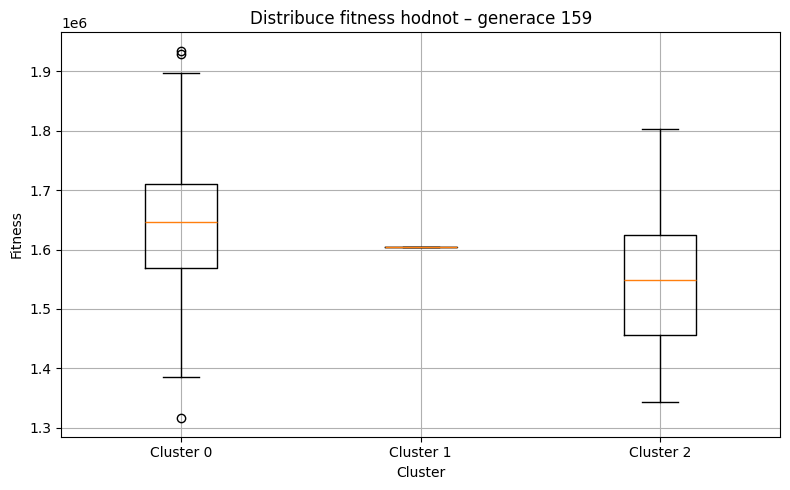

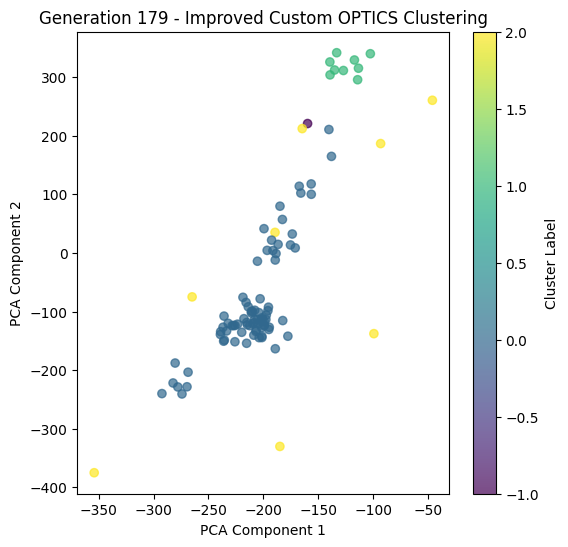

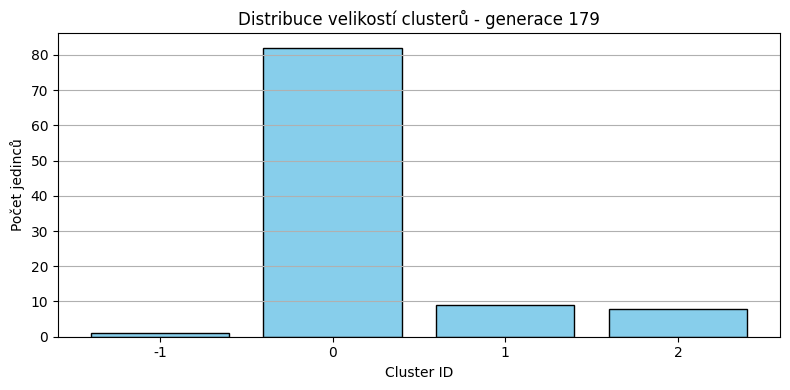


Stabilita mezi generací 0 → 19:
  Cluster -1 → -1: 1 jedinců (100.0 %)
  Cluster 0 → 0: 35 jedinců (35.4 %)
  Cluster 0 → 1: 64 jedinců (64.6 %)

Stabilita mezi generací 19 → 39:
  Cluster -1 → -1: 1 jedinců (100.0 %)
  Cluster 0 → 0: 22 jedinců (62.9 %)
  Cluster 0 → 2: 12 jedinců (34.3 %)
  Cluster 0 → 1: 1 jedinců (2.9 %)
  Cluster 1 → 2: 60 jedinců (93.8 %)
  Cluster 1 → 0: 4 jedinců (6.2 %)

Stabilita mezi generací 39 → 59:
  Cluster -1 → -1: 1 jedinců (100.0 %)
  Cluster 0 → 0: 22 jedinců (84.6 %)
  Cluster 0 → 2: 4 jedinců (15.4 %)
  Cluster 2 → 0: 12 jedinců (16.7 %)
  Cluster 2 → 2: 59 jedinců (81.9 %)
  Cluster 2 → 1: 1 jedinců (1.4 %)
  Cluster 1 → 0: 1 jedinců (100.0 %)

Stabilita mezi generací 59 → 79:
  Cluster -1 → -1: 1 jedinců (100.0 %)
  Cluster 0 → 0: 10 jedinců (28.6 %)
  Cluster 0 → 2: 24 jedinců (68.6 %)
  Cluster 0 → 1: 1 jedinců (2.9 %)
  Cluster 2 → 2: 62 jedinců (98.4 %)
  Cluster 2 → 0: 1 jedinců (1.6 %)
  Cluster 1 → 0: 1 jedinců (100.0 %)

Stabilita mezi g

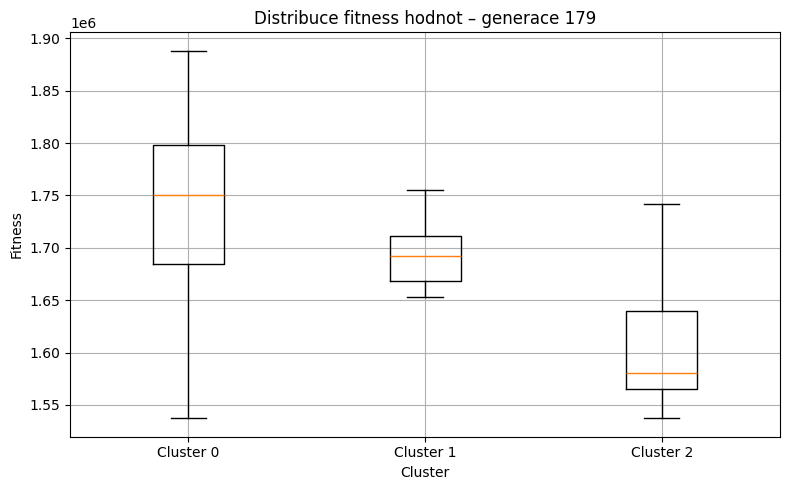

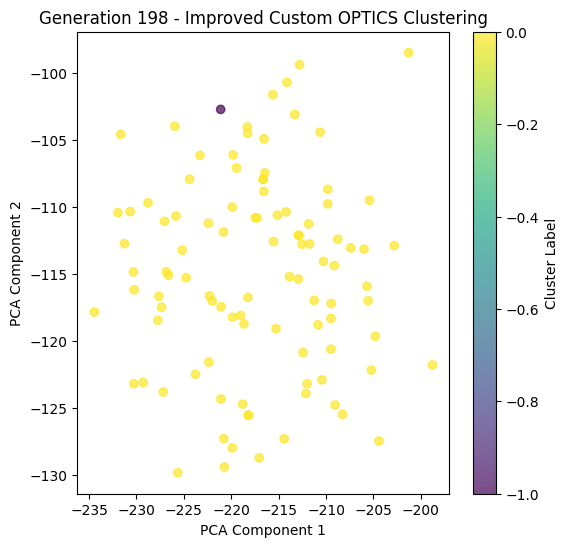

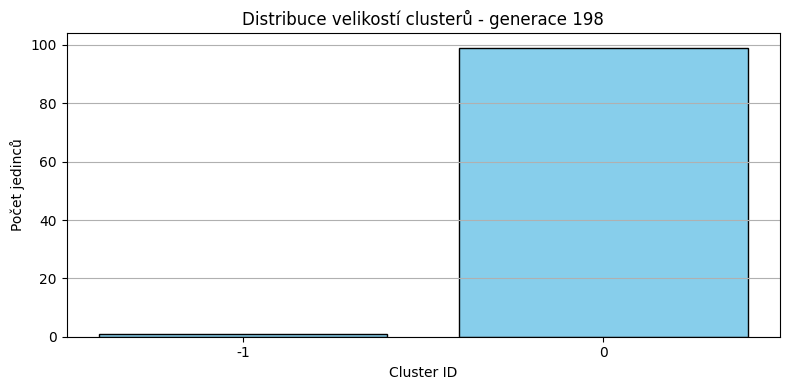


Stabilita mezi generací 0 → 19:
  Cluster -1 → -1: 1 jedinců (100.0 %)
  Cluster 0 → 0: 35 jedinců (35.4 %)
  Cluster 0 → 1: 64 jedinců (64.6 %)

Stabilita mezi generací 19 → 39:
  Cluster -1 → -1: 1 jedinců (100.0 %)
  Cluster 0 → 0: 22 jedinců (62.9 %)
  Cluster 0 → 2: 12 jedinců (34.3 %)
  Cluster 0 → 1: 1 jedinců (2.9 %)
  Cluster 1 → 2: 60 jedinců (93.8 %)
  Cluster 1 → 0: 4 jedinců (6.2 %)

Stabilita mezi generací 39 → 59:
  Cluster -1 → -1: 1 jedinců (100.0 %)
  Cluster 0 → 0: 22 jedinců (84.6 %)
  Cluster 0 → 2: 4 jedinců (15.4 %)
  Cluster 2 → 0: 12 jedinců (16.7 %)
  Cluster 2 → 2: 59 jedinců (81.9 %)
  Cluster 2 → 1: 1 jedinců (1.4 %)
  Cluster 1 → 0: 1 jedinců (100.0 %)

Stabilita mezi generací 59 → 79:
  Cluster -1 → -1: 1 jedinců (100.0 %)
  Cluster 0 → 0: 10 jedinců (28.6 %)
  Cluster 0 → 2: 24 jedinců (68.6 %)
  Cluster 0 → 1: 1 jedinců (2.9 %)
  Cluster 2 → 2: 62 jedinců (98.4 %)
  Cluster 2 → 0: 1 jedinců (1.6 %)
  Cluster 1 → 0: 1 jedinců (100.0 %)

Stabilita mezi g

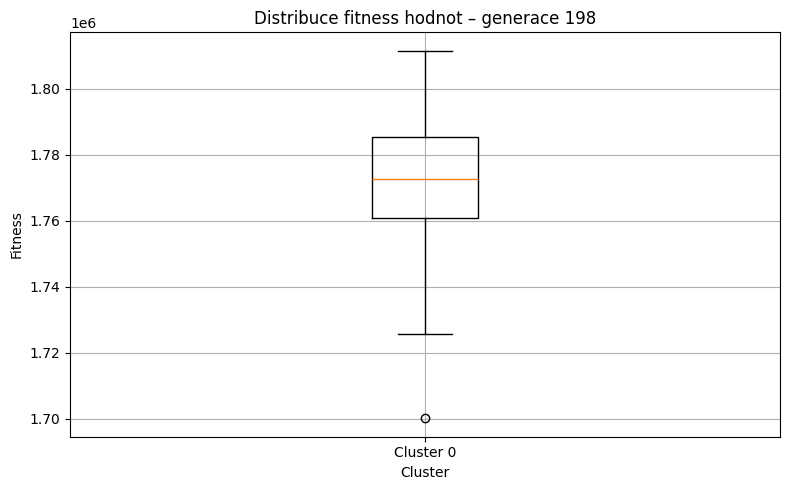

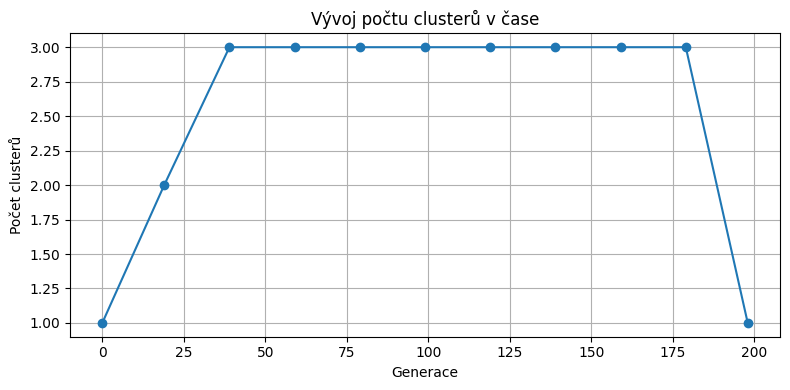

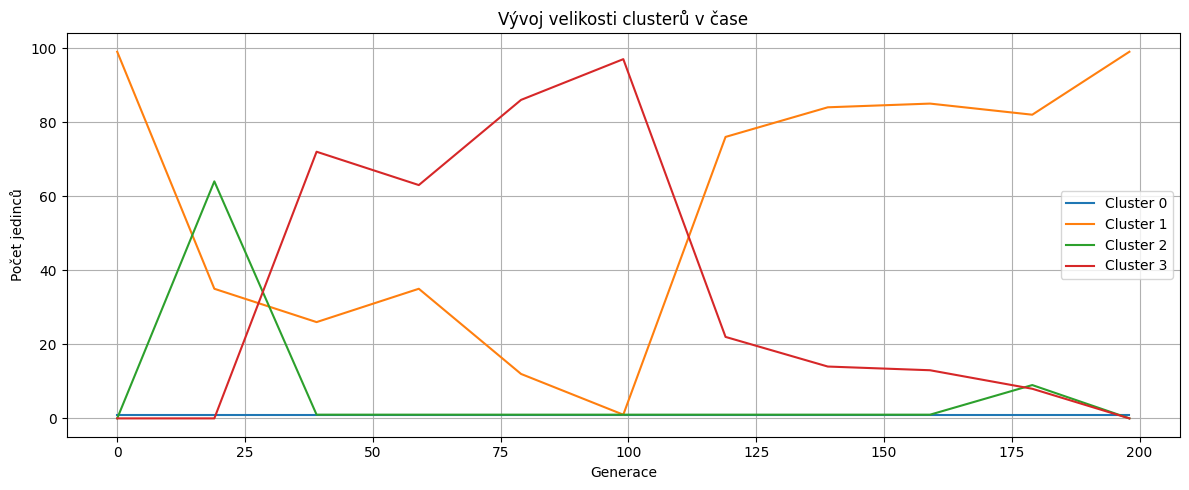

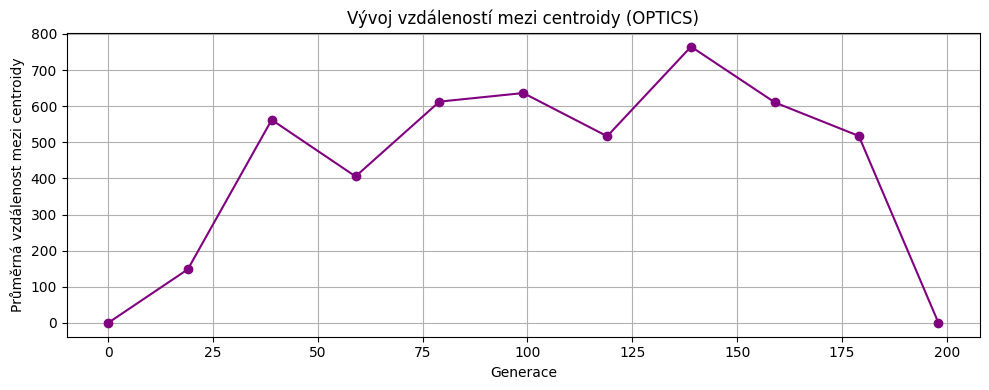


Posun centroidů mezi generací 0 a 19:
 - Cluster 0: 427.6617

Posun centroidů mezi generací 19 a 39:
 - Cluster 0: 424.6192
 - Cluster 1: 878.4544

Posun centroidů mezi generací 39 a 59:
 - Cluster 0: 184.0478
 - Cluster 1: 905.7477
 - Cluster 2: 234.6840

Posun centroidů mezi generací 59 a 79:
 - Cluster 0: 426.1669
 - Cluster 1: 856.3258
 - Cluster 2: 140.2050

Posun centroidů mezi generací 79 a 99:
 - Cluster 0: 934.0873
 - Cluster 1: 1055.8727
 - Cluster 2: 136.3599

Posun centroidů mezi generací 99 a 119:
 - Cluster 0: 761.3587
 - Cluster 1: 607.5719
 - Cluster 2: 234.4285

Posun centroidů mezi generací 119 a 139:
 - Cluster 0: 108.4264
 - Cluster 1: 924.5413
 - Cluster 2: 250.6717

Posun centroidů mezi generací 139 a 159:
 - Cluster 0: 156.6675
 - Cluster 1: 1058.5573
 - Cluster 2: 251.4845

Posun centroidů mezi generací 159 a 179:
 - Cluster 0: 214.6357
 - Cluster 1: 900.0310
 - Cluster 2: 429.8512

Posun centroidů mezi generací 179 a 198:
 - Cluster 0: 65.2908


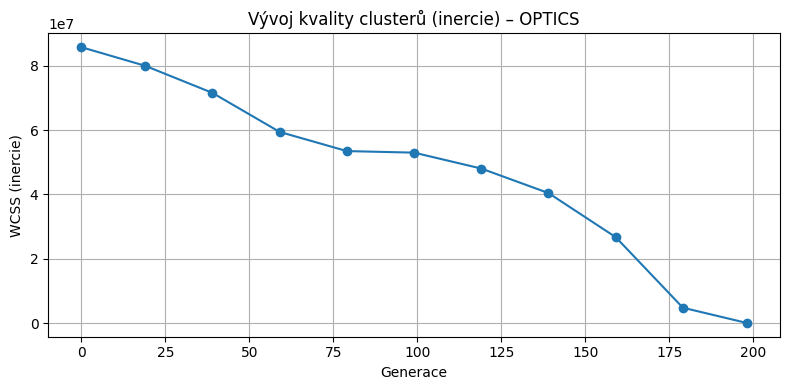

In [8]:
run("population_log_DE.csv", 3, 20)

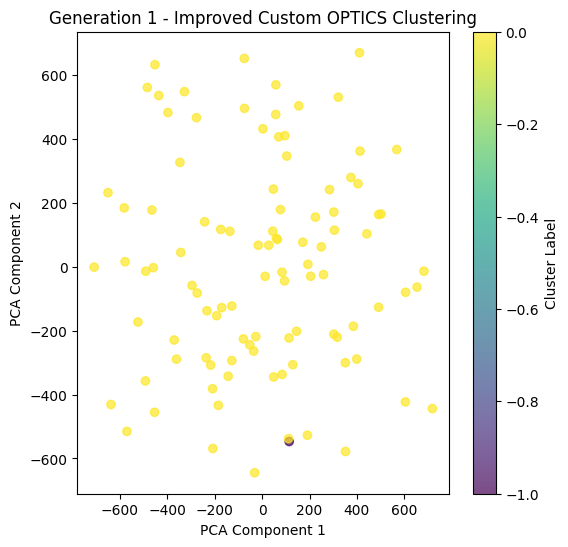

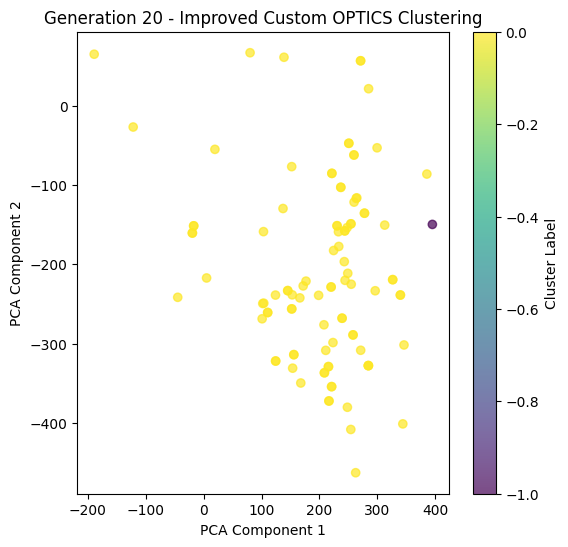

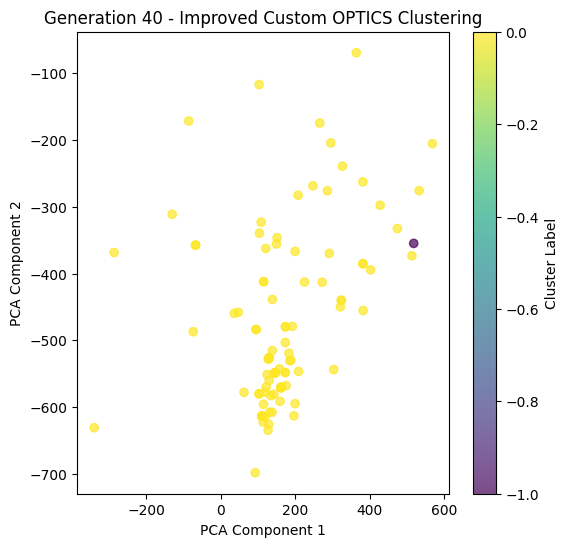

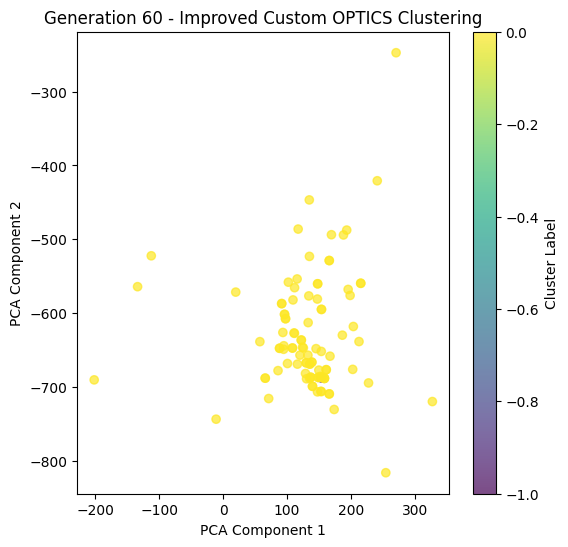

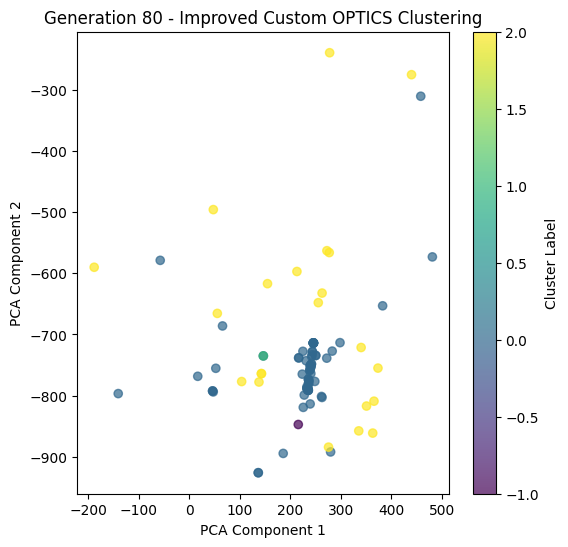

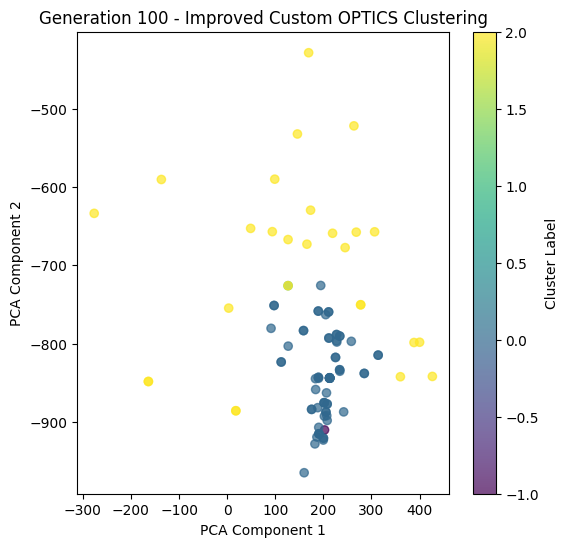

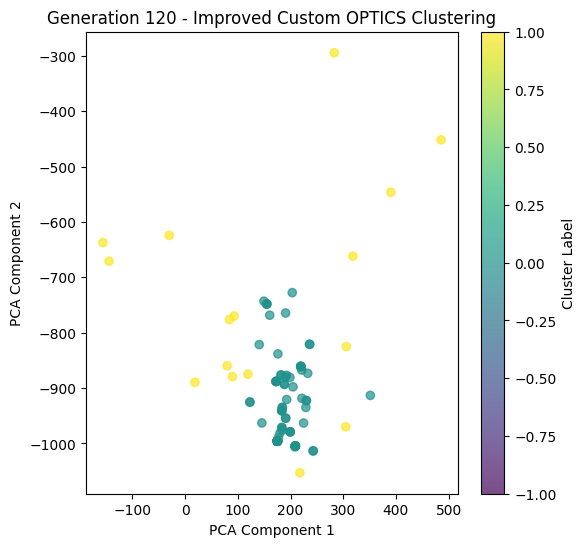

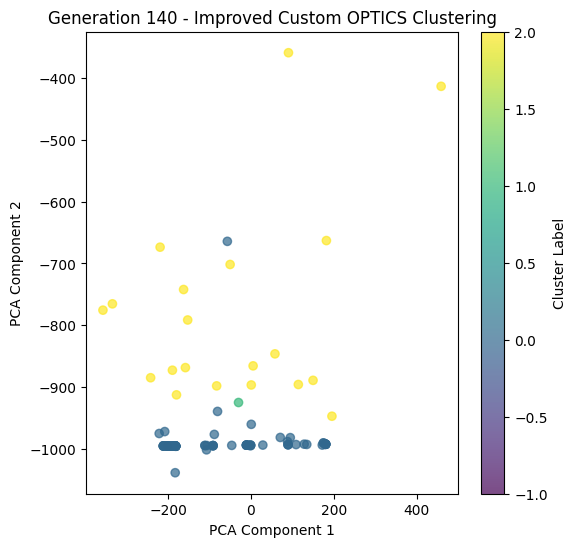

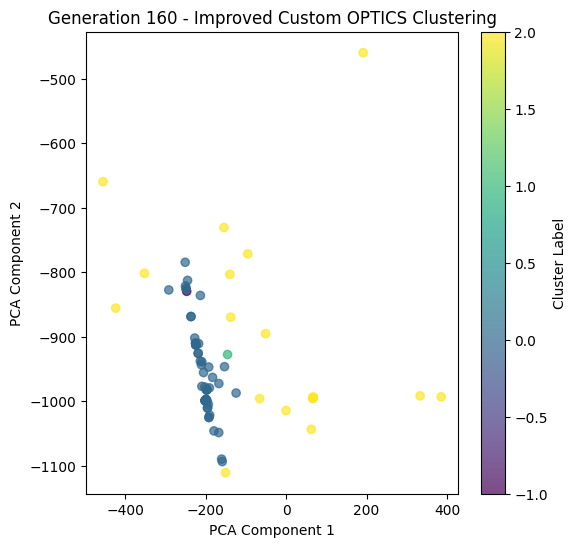

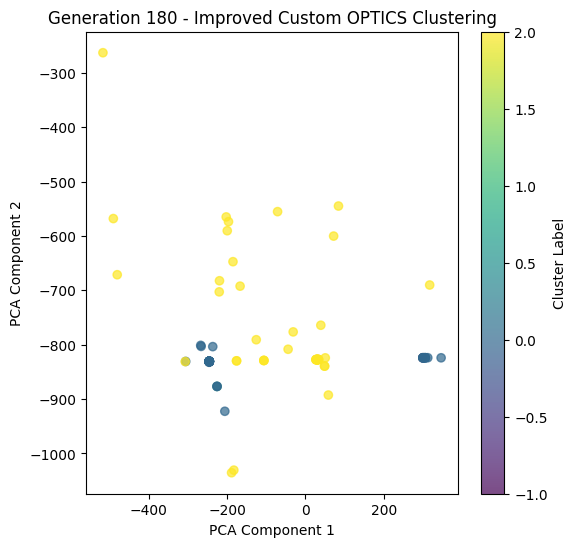

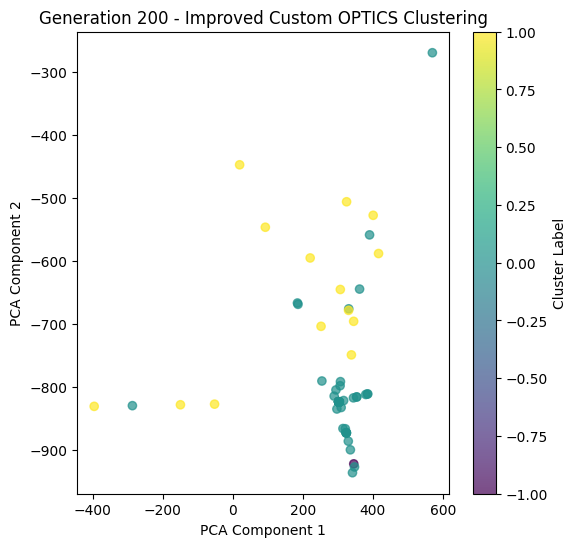

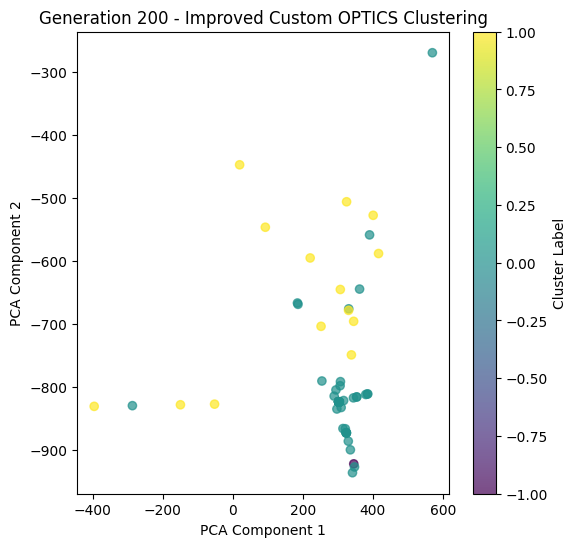

In [8]:
run("population_log_GA.csv", 5, 20)